<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module1-rnn-and-lstm/LS_DS17_431_RNN_and_LSTM_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

In [1]:
# Vanishing gradients
0.0001 ** 1000

0.0

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [10]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

""" max_features is number of the most frequent words 
collected in the bag of words. The associated number to 
each word refers to the count of that word in the dataset.
"""
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train.shape, 'train sequences')
print(len(x_test), 'test sequences')
# 25000 reviews

Loading data...
(25000,) train sequences
25000 test sequences


In [12]:
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [13]:
# Prep-padding shape
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (25000,)
x_test shape:  (25000,)


In [23]:
import pandas as pd
# repeated words in each review
pd.Series(x_train[0]).value_counts()

4       15
16      11
5        9
12       6
22       6
        ..
92       1
224      1
100      1
3941     1
98       1
Length: 123, dtype: int64

In [24]:
[len(x) for x in x_train[:10]]  # num of words from bag of 20K words in first ten reviews

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

In [25]:
# 5th review is short
x_train[5]

[1,
 778,
 128,
 74,
 12,
 630,
 163,
 15,
 4,
 1766,
 7982,
 1051,
 2,
 32,
 85,
 156,
 45,
 40,
 148,
 139,
 121,
 664,
 665,
 10,
 10,
 1361,
 173,
 4,
 749,
 2,
 16,
 3804,
 8,
 4,
 226,
 65,
 12,
 43,
 127,
 24,
 15344,
 10,
 10]

In [26]:
print('Pad Sequences (samples x time)')
#pad_sequence truncates/pads from the beginning
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [32]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [27]:
x_train[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,   778,   128,    74,    12,   630,   163,    15,
           4,  1766,  7982,  1051,     2,    32,    85,   156,    45,
          40,   148,   139,   121,   664,   665,    10,    10,  1361,
         173,     4,   749,     2,    16,  3804,     8,     4,   226,
          65,    12,    43,   127,    24, 15344,    10,    10],
      dtype=int32)

In [36]:
model = Sequential()
# we are predicting the imdb review sentiment (output =1)

# convert 20K inputs to 128 embeddings (2560K params)
model.add(Embedding(max_features, 128))
# https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout
# not related to the above 128 embedding
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [34]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=2, 
          validation_data=(x_test,y_test))

Epoch 1/2
782/782 [==============================] - 216s 276ms/step - loss: 0.4313 - accuracy: 0.7969 - val_loss: 0.3688 - val_accuracy: 0.8432
Epoch 2/2
782/782 [==============================] - 215s 275ms/step - loss: 0.2615 - accuracy: 0.8959 - val_loss: 0.3713 - val_accuracy: 0.8402


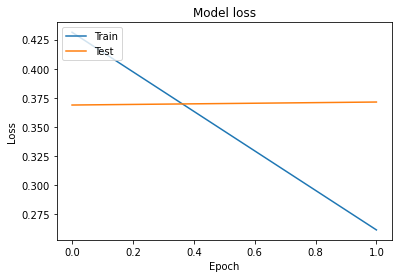

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [38]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import os

* The dataset consists of 136 new articles each article in one row

In [39]:
import pandas as pd

df = pd.read_json('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/wp_articles.json')
df.head()

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


In [40]:
print(df.shape)
df.iloc[0,:]

(136, 1)


article    Contributing columnist\n\nThe House is on fire...
Name: 0, dtype: object

In [17]:
# data_files = os.listdir('./articles')  # If you're running locally

In [41]:
df['article'][0]

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

In [19]:
# # Read in Data

# data = []

# for file in data_files:
#     if file[-3:] == 'txt':
#         with open(f'./articles/{file}', 'r', encoding='utf-8') as f:
#             data.append(f.read())

In [42]:
data = df['article'].values
print(data.shape, type(data))

(136,) <class 'numpy.ndarray'>


In [43]:
data[0]

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

In [44]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
#.join is a string method. joining each row of the ndarray to another row with a white space
text = " ".join(data)

# Unique Characters, enumerate(set(text)) would produce random indexing at every run
chars = list(set(text))

# Lookup Tables 
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [45]:
set(text)

{'\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '©',
 '\xad',
 '·',
 '½',
 '×',
 'á',
 'ã',
 'è',
 'é',
 'ê',
 'í',
 'ñ',
 'ó',
 'ö',
 '–',
 '—',
 '―',
 '‘',
 '’',
 '“',
 '”',
 '•',
 '…',
 '\u2066',
 '\u2069',
 '⅓',
 '⅔',
 '●',
 '⭐',
 'ﬂ',
 '👻',
 '🗣',
 '🤔'}

In [46]:
print(len(text), type(text))
text[:50]

891910 <class 'str'>


'Contributing columnist\n\nThe House is on fire. And '

In [47]:
print(len(chars))

121


In [48]:
char_int[' ']

46

In [49]:
int_char[57]

'🤔'

In [50]:
len(chars)

121

In [51]:
# Create the sequence data
# sample the character sequence of 40 characters every 5 character
# reducing the step is similar to reducing the learning curve. 
# Increasing the length of each element of sequence is similar to increasing the batch_size

maxlen = 40
step = 5

# iterate through each character of the text
encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One character for each element of sequence

for i in range(0, len(encoded) - maxlen, step):
    sequences.append(encoded[i : i + maxlen])
    # next_char refers to the character encoding right after the last character of the sequence in encoded list
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences), len(encoded)/step)

sequences:  178374 178382.0


In [52]:
encoded[40], sequences[1][35], next_char[0]

(91, 91, 91)

In [53]:
print(int_char[encoded[0]])
encoded[:10]

C


[92, 79, 112, 90, 83, 74, 26, 96, 90, 74]

In [54]:
print(len(text), len(encoded))

891910 891910


In [55]:
print(len(sequences[0]), sequences[0])

40 [92, 79, 112, 90, 83, 74, 26, 96, 90, 74, 112, 48, 46, 77, 79, 110, 96, 47, 112, 74, 93, 90, 99, 99, 13, 64, 87, 46, 100, 79, 96, 93, 87, 46, 74, 93, 46, 79, 112, 46]


In [34]:
print()


In [56]:
# Create x & y

# Padding!
x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)
test = []
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        # x[sequence#[0:137], char index in sequence[0:40], char encoded value[0:121]]
        # 1 is stored as boolean type
        x[i,t,char] = 1
        test.append((i,t,char))
    # y[sequence, next character after sequence in embeded]   
    y[i, next_char[i]] = 1

In [57]:
# each sequence is on one row of axis=0, and will have boolean value(T/F)
x.shape

(178374, 40, 121)

In [58]:
y.shape

(178374, 121)

In [59]:
for i in test[:5]:
  print(x[i])
test[-5:]

True
True
True
True
True


[(178373, 35, 87),
 (178373, 36, 87),
 (178373, 37, 46),
 (178373, 38, 44),
 (178373, 39, 87)]

In [60]:
# build the model: a single LSTM
# x is the input sequence
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# y is the output next character after the sequence
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [61]:
4*(121+128+1)*128

128000

* n=input dimension=len(chars)=121, maxlen says that only 40 of the 121 inputs are True

* m=# of lstm in layer, # paramters = 4*(n+m+1)*m
* output parameters = (128 parallel lstm + 1 bias)* 121 (character set or output)

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               128000    
_________________________________________________________________
dense_3 (Dense)              (None, 121)               15609     
Total params: 143,609
Trainable params: 143,609
Non-trainable params: 0
_________________________________________________________________


In [63]:
def sample(preds):
    """
    It normalizes the array of preds to proba (with their sum equal to 1)
    Then it picks the index of the first maximum based on a random draw with the proba array weight
    """
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    
    # Null operation
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    
    # Normalize to the sum of one for the array of probabilities
    preds = exp_preds / np.sum(exp_preds)
    
    probas = np.random.multinomial(1, preds, 1)
    
    # Returns the indices of the maximum values along an axis.
    return np.argmax(probas)

In [64]:
np.random.multinomial(1, [1/3]*3, 2)
ss = np.random.multinomial(1, [1/6, 1/3, 1/2], 1)
print(ss)
np.argmax(ss)

[[1 0 0]]


0

In [65]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    # Random prompt to grab a 40 character sample seed
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        # 400 is the length of generated text
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        # Predict the next step (character)
        # preds is an array of length 121 
        # with all the elements zero except only one of them 1
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        # update the seed by moving one character forward
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [66]:
# fit the model

model.fit(x, y,
          batch_size=32,
          epochs=10,
          callbacks=[print_callback])

Epoch 1/10
5575/5575 [==============================] - ETA: 0s - loss: 2.5548
----- Generating text after Epoch: 0
----- Generating with seed: "ow while responding to a call about an o"
ow while responding to a call about an orz isllyTs go dbin 1n That loatiges spwatsole tians, Kare Tred cans lizs redap wit werkons whall siers, Aoe hed conkan Alcack, ajvit a dfut ij wa Ued the was las out ond an of irces equns. Mat Nan to Rsirntoces Meve$ santed Mamen. fo d d jiy, Laln sobop Hote Res in pimscos walr all erns ive’s, Jow ivpan hers treas.

L

Tha chat cayro a n)Maill in and -chopld, Guryade, un a dswend Fesle


Thoud fur
5575/5575 [==============================] - 254s 46ms/step - loss: 2.5548
Epoch 2/10
5575/5575 [==============================] - ETA: 0s - loss: 2.2140
----- Generating text after Epoch: 1
----- Generating with seed: "l shows that during the exchange, Trump "
l shows that during the exchange, Trump a Cand Wa han tle sal sreedrarzipntwanco, im Butep PCaquippalk ford im

KeyboardInterrupt: ignored

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 